In [97]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml imbalanced-learn

In [98]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
# from imblearn.under_sampling import RandomUnderSampler

# Práctica 4: Overfitting

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones. Cada función está marcada por &#x1F625;,  &#x1F643; o &#x1F921;. Las marcas indican:

- &#x1F625;: Indican una entrega que debe ser hecha dentro de la misma sesión de la asignación. 
- &#x1F643;: Indican una entrega que puede ser hecha hasta la siguiente sesión.
- &#x1F921;: Debe mostrar un avance en la misma sesión, pero la entrega puede ser hecha en la siguiente.

Aquellas entregas parciales que no sean hechas el día de la asignación ya no serán válidas para las entregas totales, sin embargo, las entregas totales seguirán siendo válidas.

En esta sección se incluye un dataset real. El dataset importado se llama LDPA y puede leer su descripción en la siguiente liga

https://www.openml.org/d/1483

In [99]:
# Descarga la metadata del dataset
dataset_info = openml.datasets.get_dataset(1483, download_data=False)

# Obtiene el nombre de la columna a predecir
target = dataset_info.default_target_attribute

(
    features, # Dataframe con las características que se pueden utilizar para predecir
    outputs, # Columna a predecir
    categorical_mask, # Máscara que indica que columnas de todas las características son categoricas
    columns # Lista con el nombre de las características
)= dataset_info.get_data(
    dataset_format="dataframe", target=target
)

categorical_mask = np.array(categorical_mask)
columns = np.array(columns)

In [100]:
print(f"La columna a predecir se llama '{target}'")
print(f"Todas las características son {str(columns)}")
print(f"Las características categóricas son {str(columns[categorical_mask])}")
print(f"Las características numéricas son {str(columns[~categorical_mask])}")

La columna a predecir se llama 'Class'
Todas las características son ['V1' 'V2' 'V3' 'V4' 'V5' 'V6' 'V7']
Las características categóricas son ['V1' 'V2']
Las características numéricas son ['V3' 'V4' 'V5' 'V6' 'V7']


In [101]:
# Impresión de las características
features

,V1,V2,V3,V4,V5,V6,V7
0,1,1,105794.0,105777.0,148933.0,108479.0,109365.0
1,1,4,105795.0,105778.0,155325.0,96952.0,161363.0
2,1,3,105796.0,105779.0,156652.0,101610.0,148870.0
3,1,1,105797.0,105780.0,149736.0,107135.0,102479.0
4,1,2,105798.0,105781.0,155978.0,125455.0,106203.0
...,...,...,...,...,...,...,...
164855,5,2,43687.0,43679.0,106611.0,123166.0,12432.0
164856,5,1,43688.0,43680.0,120821.0,119848.0,87463.0
164857,5,4,43689.0,43681.0,104999.0,110823.0,161536.0
164858,5,2,43690.0,43682.0,102191.0,112520.0,10811.0


In [102]:
outputs

0         3
1         3
2         3
3         3
4         3
         ..
164855    3
164856    3
164857    3
164858    3
164859    3
Name: Class, Length: 164860, dtype: category
Categories (11, object): ['1' < '2' < '3' < '4' ... '8' < '9' < '10' < '11']

A continuación se realiza la partición de __train__ y __test__. __No debe utilizar la partición de test por ningún motivo__.

In [103]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    features, 
    outputs, 
    test_size=0.5, 
    random_state=11
)

## Asignación 1 &#x1F921;

Utilizando las técnicas vistas en clase, realicé su mejor esfuerzo para obtener el mejor modelo lineal posible utilizando __únicamente el conjunto de entrenamiento__ (X_train y y_train). Puede utilizar bibliotecas, pero únicamente las técnicas vistas en clase y debe ir generando métricas o visualizaciones que respalden su toma de decisiones. Debe tener e imprimir una estimación de $E_{out}$ utilizando su conjunto de entrenamiento. La métrica utilizada será la entropía cruzada.

- **V1** = {A, B, C, D, E} = 5 people
- **V2** = {ANKLE_LEFT, ANKLE_RIGHT, CHEST, BELT}
- **V3** = timestamp (Numeric) all unique
- **V4** = date FORMAT (Date)
- **V5** = x coordinate of the tag (Numeric)
- **V6** = y coordinate of the tag (Numeric)
- **V7** = z coordinate of the tag (Numeric)
- **output** = activity = {'walking', 'falling', 'lying down', 'lying', 'sitting down', 'sitting', 'standing up from lying', 'on all fours', 'sitting on the ground', 'standing up from sitting', 'standing up from sitting on the ground'} (Nominal)

Primero, graficamos la distribución de los datos de V1 y V2, siendo variables categóricas, la primera el número de identificación de la persona (V1) y en qué parte del cuerpo se colocó el sensor (V2).

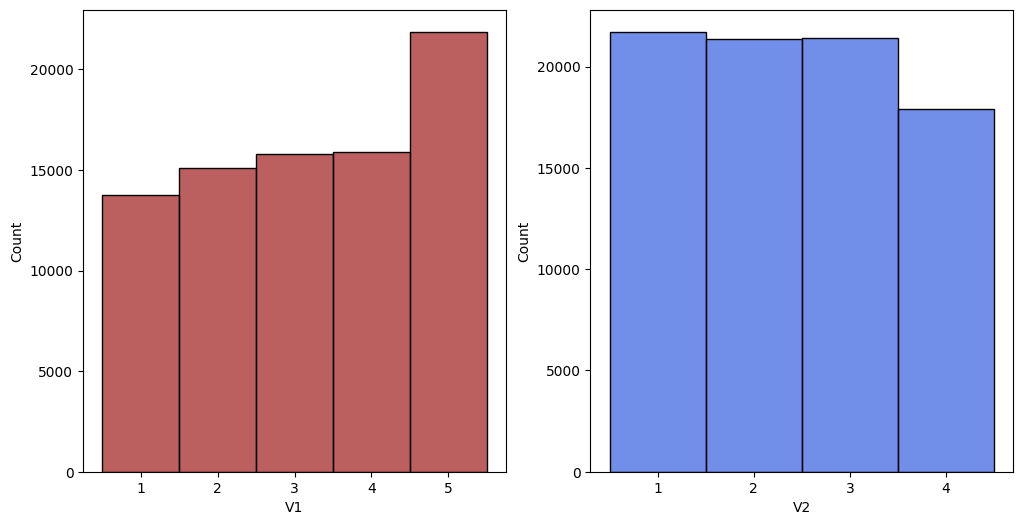

In [104]:
columns = ["V1", "V2"]
colors = ["brown", "royalblue"]
fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(12, 6))

for i, col in enumerate(columns):
    sns.histplot(data = X_train, x = col, ax = axs[i], color=colors[i])

Graficamos la distribución de los datos V5, V6 y V7, que serían las coordenadas (x, y, z).

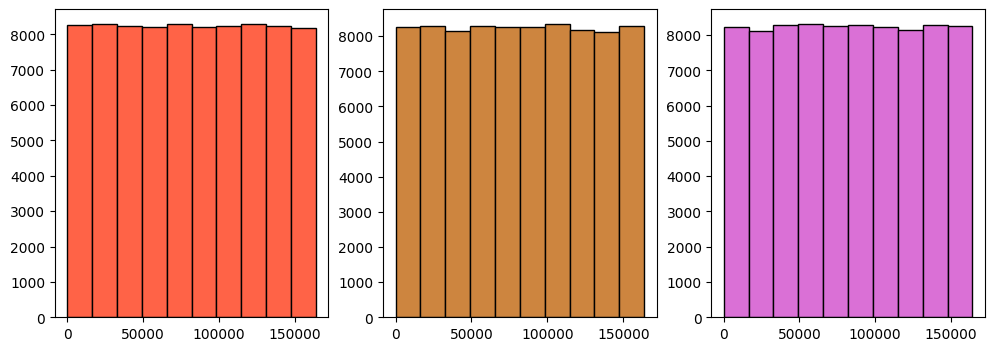

In [105]:
columns = ["V5", "V6", "V7"]
colors = ["tomato", "peru", "orchid"]
fig, axs = plt.subplots(ncols=3, nrows= 1, figsize=(12, 4))

for i, col in enumerate(columns):
    axs[i].hist(x = X_train[col].values, color=colors[i], edgecolor="black")

Veremos qué tan balanceadas están las clases a predecir.

<Axes: xlabel='Class', ylabel='Count'>

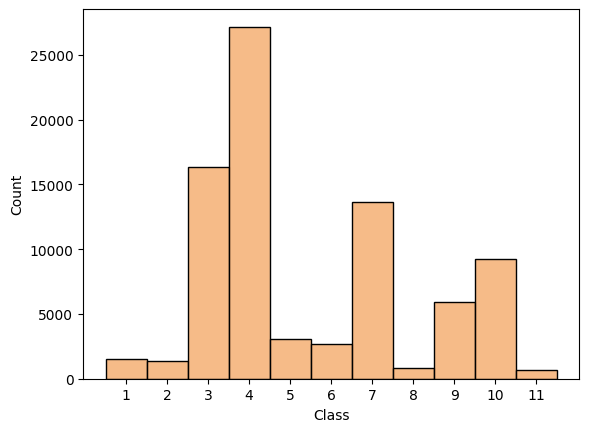

In [106]:
# Distribución de las clases a predecir
sns.histplot(x = y_train, color="sandybrown")

*Como se puede observar, existe un desbalance de clases a predecir, por lo que dentro del preprocesamiento trataremos de balancearlas usando la técnica 'undersample', usando la estrategia de eliminar registros de la característica con mayor frecuencia.* *$^1$

In [107]:
# Se explica más a detalle al final

# undersample = RandomUnderSampler(sampling_strategy={"3": 8000, "4": 14000, "7": 6500, "10":4000})
# undersample = RandomUnderSampler(sampling_strategy='majority')
# X_train, y_train = undersample.fit_resample(X_train, y_train)

Ya que las características están V5, V6 y V7 son coordenadas del sensor, podríamos ver cómo se comportan estos datos graficándolos tridimensionalmente.

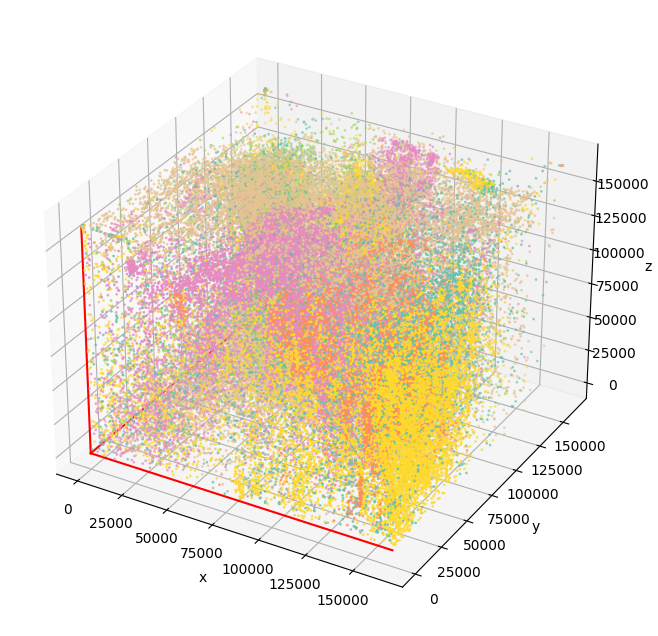

In [108]:
fig = plt.figure(figsize=(8,8))

# Clasificamos los colores dependiendo de la acividad realizada
color=y_train.cat.codes
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train['V5'], X_train['V6'], X_train['V7'], c=color, cmap="Set2_r", s=1)
 
xAxisLine = ((min(X_train['V5']), max(X_train['V5'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(X_train['V6']), max(X_train['V6'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(X_train['V7']), max(X_train['V7'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

Observamos que no existe una separación o patrón visible entre las coordenadas (V5, V6, V7) y la actividad a predecir (y_train). 

Sin embargo, podríamos ver si se enucuentra algún patrón al graficar los primeros 2 componentes del análisis de componentes principales.

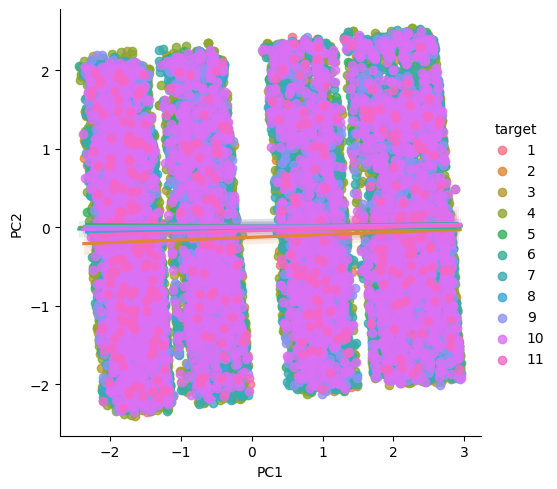

In [109]:
pca = PCA(n_components=3)

# Escalamos los datos
x_scaled = StandardScaler().fit_transform(X_train)

pca_features = pca.fit_transform(x_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])
pca_df['target'] = y_train

# Gaficamos los datos dependiendo del target
sns.lmplot(x='PC1',  y='PC2',  data=pca_df,  hue='target', legend=True)

Vemos que hay como clusters, esto podría ser por la correlación entre algunas variables, veremos si podemos eliminar algunas características.

In [110]:
# Correlación entre las características del X_train
corr_x = X_train.corr()
# Imprimimos las características que poseen mayor correlación
print(corr_x.abs().unstack().drop_duplicates().sort_values(ascending=False))

V3  V3    1.000000
    V4    1.000000
V5  V6    0.366917
V3  V5    0.090484
V4  V5    0.090482
    V7    0.026448
V3  V7    0.026448
V5  V7    0.026174
V4  V6    0.022802
V3  V6    0.022801
V6  V7    0.013580
dtype: float64


C:\Users\Iván\AppData\Local\Temp\ipykernel_27224\3726137724.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_x = X_train.corr()


Eliminamos las características con mayor correlación, siendo las columnas que tienen que ver con el tiempo, por lo que eliminamos ambas (V3, V4).

In [111]:
X_train = X_train.drop(columns=['V3', 'V4'])
X_test = X_test.drop(columns=['V3', 'V4'])
X_train

,V1,V2,V5,V6,V7
82677,3,3,72476.0,106489.0,146328.0
2843,1,1,135179.0,75851.0,79479.0
50670,2,2,76316.0,137080.0,101775.0
128441,5,4,97161.0,128160.0,137973.0
10592,1,2,70382.0,140689.0,119402.0
...,...,...,...,...,...
102327,4,2,146134.0,114564.0,47575.0
97617,4,2,54989.0,81198.0,26584.0
21584,1,1,44795.0,105412.0,49255.0
36543,2,2,59207.0,33106.0,114460.0


Ahora, sin las características con mucha correlación, veremos cómo se comporta el gráfico del Análisis de componentes principales.

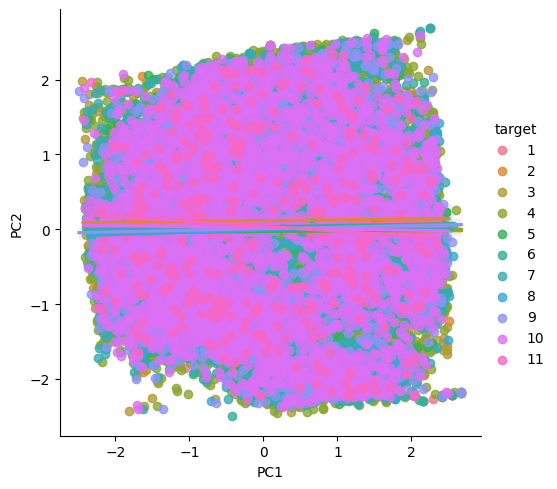

In [112]:
pca = PCA(n_components=3)

# data scaling
x_scaled = StandardScaler().fit_transform(X_train) 
# x_scaled = StandardScaler().fit_transform(features) 

pca_features = pca.fit_transform(x_scaled)
 
pca_df = pd.DataFrame(
    data=pca_features, 
    columns=['PC1', 'PC2', 'PC3'])
pca_df['target'] = y_train

sns.lmplot(x='PC1',  y='PC2',  data=pca_df,  hue='target', legend=True)

Observamos que los clústers de antes si se formaban con por la correlación entre las características de tiempo.

Ahora, buscaremos el mejor modelo lineal para entrenar los datos.

Para los datos numéricos se va a plicar el escalado de mínimos y máximos, y para las variables categóricas como la persona (V1) y el lugar del sensor en el cuerpo (V2), one hot encoder.

*Además, dado que son casi únicas las coordedanas (V5, V6, V7), podríamos quitarles algunos ordenes de magnitud para que exista algún tipo de agrupación y sea mejor el modelo.* *$^2$

In [113]:
columns = ["V5", "V6", "V7"]

for i, col in enumerate(columns):
    # Redondeamos las coords para X_train
    new_val = X_train[col].values
    new_val = new_val*(1/1000)
    # X_train[col] = np.round(new_val)

    # Redondeamos las coords para X_test
    new_val = X_test[col].values
    new_val = new_val*(1/1000)
    # X_test[col] = np.round(new_val)

In [114]:
# Inicializamos el preprocesamiento general
preprocess_minmax = make_column_transformer(
    (MinMaxScaler(), ['V5', 'V6', 'V7']),
    (OneHotEncoder(), ['V1', 'V2'])
)

# El número de pliegues para crossvalidation
cv = KFold(n_splits = 16, shuffle = True)

In [115]:
# Inicializamos pipeline para una regresión logística
pipe_LR = Pipeline(steps=[
    ('preprocess', preprocess_minmax),
    ('model_LR', LogisticRegression(solver="sag", multi_class='multinomial', max_iter = 10000))
])

# Calculamos E_out
scores_LR = cross_val_score(pipe_LR, X_train, y_train, cv= cv)
print("%0.4f de error con una desviación de %0.4f" % (1 - scores_LR.mean(), scores_LR.std()))

0.6067 de error con una desviación de 0.0056


In [116]:
# Inicializamos pipeline para una gradiente estocástico con entropía cruzada
pipe_SGD = Pipeline(steps=[
    ('preprocess', preprocess_minmax),
    ('model_SGD', SGDClassifier(loss='log_loss', max_iter = 10000))
])

# Calculamos E_out
scores_SGD = cross_val_score(pipe_SGD, X_train, y_train, cv= cv)
print("%0.4f de error con una desviación de %0.4f" % (1 - scores_SGD.mean(), scores_SGD.std()))

0.6081 de error con una desviación de 0.0097


Observamos que tanto la regresión logística y el gradiente descendiente poseen poca exactitud en el modelo, sin embargo, la regresión logística es un poco superior al gradiente descendiente. 

Por lo que procedemos a entrenar usando la regresión logística.

In [117]:
# Entrenamos usando regresión logística
pipe_LR.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['V5', 'V6', 'V7']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['V1', 'V2'])])),
                ('model_LR',
                 LogisticRegression(max_iter=10000, multi_class='multinomial',
                                    solver='sag'))])

## Asignación 2 &#x1F921;

Evalue su modelo final en el conjunto de test (X_test y y_test). Su práctica será evaluada acorde a las técnicas aplicadas, la estimación de $E_{out}$, el valor de $E_{test}$, y contra las métricas obtenidas por sus compañeros.

[Text(0.5, 1.0, 'Prediction')]

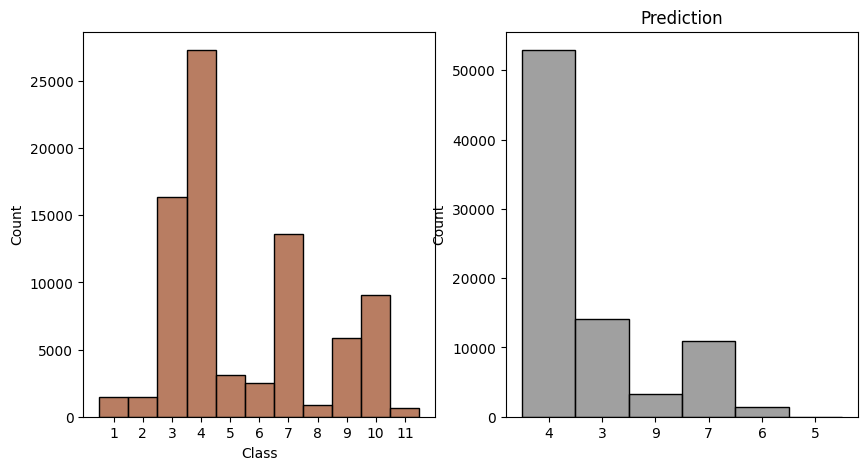

In [118]:
# Calculamos las predicciones a partir del conjunto de prueba
y_pred = pipe_LR.predict(X_test)

# Graficamos la distribución de cómo se debería de ver y cómo
# se observa el target de prueba y el target predicho
fig, axs = plt.subplots(ncols=2, nrows= 1, figsize=(10, 5))
sns.histplot(x = y_test, ax = axs[0], color="sienna")
sns.histplot(x = y_pred, ax = axs[1], color="grey").set(title='Prediction')

Se ve que el gran problema del modelo, es que pierde por completo las clases 1, 2, 8, 10 y 11, a lo mejor si sólo se usaran menos clases se lograría mejorar el modelo lineal. El error de prueba está dado por:

In [119]:
print("%0.4f de error en el conjunto predicho." % (1 - accuracy_score(y_test, y_pred)))

0.6055 de error en el conjunto predicho.


Finalmente, tenemos que $E_{out} = 0.6065$ y $E_{test} = 0.6055$, siendo $E_{out} \approx  E_{test}$, realmente este no es un buen modelo, sin embargo, es casi a lo mejor se se pudo llegar usando un modelo lineal, además de que las clases están realmente desbalanceadas. 

En uno de los intentos para minimizar el error usando preprocesamiento, se buscó agrupar algunas clases a predecir, por ejemplo, *sitting = sitting on the ground*, sin embargo, asumiendo que las clases están en el orden en como aprece en el origen de los datos, quedaban las clases agrupadas igualmente con mala distribución y predecía la gran mayoría en donde se encontraba la clase 4 (*lying*), eliminando por completo las demás características. También se buscó balancear un poco las clases usando la técnica de *undersampler* $*^1$, ya sea minimizando aleatoriamente a la clase con mayor número de muestras o de manera muy regular, pero al hacer esto si se perdía demasiada información y en su caso minimizaba el $E_{out}$ pero el $E_{test}$ lo hacía muy alto, por lo que hacía cierto overfitting, esto debido a que al eliminar muestras aleatorias de ciertas clases, por consecuencia, se desbalanceaban las demás características que sí están balanceadas.

El otro intento para minimizar el error *$^2$, fue agrupar las coordenadas (x, y, z) eliminando ordenes de magnitud, para que se encontrara algún patrón, sin embargo, esto si funcionó en parte pero sólo mejoró el modelo un $0.1%$, por lo que es mejor mantener los datos intactos.